In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from glob import glob
from datetime import datetime
# import warnings
# warnings.filterwarnings("ignore")

import shutil

# Project
project_common_path = os.path.dirname('.')
project_common_path = os.path.abspath(os.path.join(project_common_path, '..', 'common'))
if not project_common_path in sys.path:
    sys.path.append(project_common_path)

In [3]:
import matplotlib.pylab as plt
%matplotlib inline

In [4]:
os.environ['THEANO_FLAGS'] = 'device=cpu'

from data_utils import TRAIN_CSV_FILEPATH, TRAIN_CSV, TRAIN_ENC_CSV, get_caption, train_jpg_ids
from image_utils import get_image_data, scale_percentile

In [6]:
img = get_image_data("0", "Train_tif")
img.min(), img.max(), img.dtype, img.shape

(2469, 8527, dtype('uint16'), (256, 256, 4))

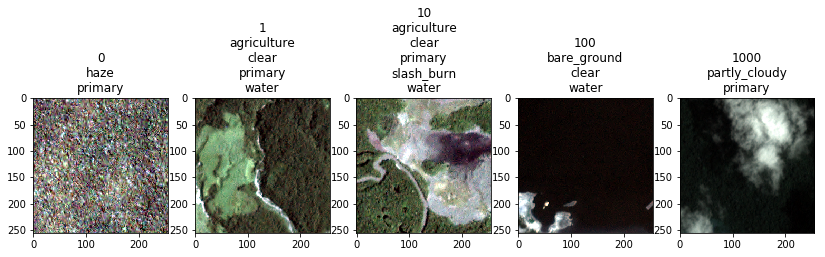

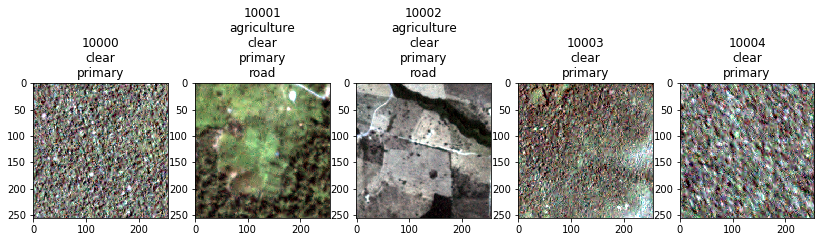

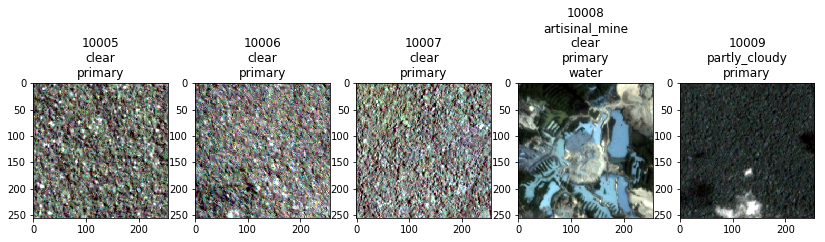

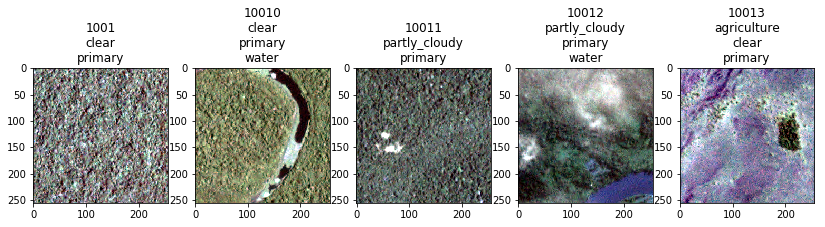

In [7]:
n = 5
counter = 0
for image_id in train_jpg_ids[:20]:
    img = get_image_data(image_id, "Train_tif")
    caption = get_caption(image_id, "Train_tif")
    if counter % n == 0:
        plt.figure(figsize=(14, 5))
    plt.subplot(1, n, counter % n + 1)
    plt.imshow(scale_percentile(img[:,:,:3]))
    plt.title(image_id + "\n" + caption.replace(' ', '\n'))
    counter += 1

In [8]:
img = get_image_data("0", "Train_tif")
img.min(), img.max(), img.dtype, img.shape

(2469, 8527, dtype('uint16'), (256, 256, 4))

## Water detection with NDWI

In [29]:
from data_utils import get_id_type_list_from_df, TRAIN_ENC_CL_CSV, unique_tags, get_id_type_list_for_class, equalized_data_classes, to_set
from training_utils import get_gen_flow, get_id_imgaug_seq
from xy_providers import image_label_provider, tif_image_label_provider

In [24]:
unique_tags

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [25]:
water_mask = TRAIN_ENC_CL_CSV['water'] == 1
agriculture_mask = TRAIN_ENC_CL_CSV['agriculture'] == 1
cloud_mask = TRAIN_ENC_CL_CSV['cloudy'] == 1
df = TRAIN_ENC_CL_CSV[water_mask | agriculture_mask | cloud_mask]

In [26]:
df[['image_id', 'water']].tail()

image_id  water
40473     40473      0
40475     40475      0
40476     40476      0
40477     40477      0
40478     40478      0

In [27]:
id_type_list = get_id_type_list_from_df(df, image_type='Train_tif')
len(id_type_list)

19103

In [49]:
class_index = 0
trainval_id_type_list = get_id_type_list_for_class(class_index, 'Train_tif')

class_indices = list(equalized_data_classes.keys())
class_indices.remove(class_index)

n_other_samples = int(len(trainval_id_type_list) * 1.0 / len(class_indices))

for index in class_indices:
    id_type_list = np.array(get_id_type_list_for_class(index, 'Train_tif'))
    id_type_list = list(to_set(id_type_list) - to_set(trainval_id_type_list))
    np.random.shuffle(id_type_list)
    trainval_id_type_list.extend(id_type_list[:n_other_samples])

In [50]:
# train_id_type_list = id_type_list
len(trainval_id_type_list)

2785

In [51]:
n_limit = -1

params = {
    'seed': 2017,
    'normalize_data': False,
    'normalization': '',
    'image_size': (256, 256),
    'batch_size': 5,
    'save_prefix': 'check_data_iterators',
    'xy_provider': tif_image_label_provider,
    'class_index': 0,
}
channels_first = False

In [52]:
import numpy as np
import cv2

def to_ndwi(img):
    """
    NDWI = (Xgreen – Xnir)/(Xgreen + Xnir)
    """
    b, g, r, ir = img[:, :, 0], img[:, :, 1], img[:, :, 2], img[:, :, 3] 
    g = g.astype(np.float32)
    ir = ir.astype(np.float32)    
    return (g - ir) / (g + ir + 1e-10)


def to_lightness(img):
    img32 = img.astype(np.float32)
    hls32 = cv2.cvtColor(img32, cv2.COLOR_RGB2HLS)
    l32 = hls32[:, :, 1]
    return l32

def to_ndvi(img):
    """
    NDVI = (Nir - r) / (Nir + r)
    """
    b, g, r, ir = img[:, :, 0], img[:, :, 1], img[:, :, 2], img[:, :, 3]
    r = r.astype(np.float32)
    ir = ir.astype(np.float32)        
    return (ir - r) / (r + ir + 1e-10)


def to_rgb(img):
    b, g, r, ir = img[:, :, 0], img[:, :, 1], img[:, :, 2], img[:, :, 3]
    out = np.zeros(img.shape[:-1] + (3, ), dtype=img.dtype)
    out[:, :, 0] = r[:, :]
    out[:, :, 1] = g[:, :]
    out[:, :, 2] = b[:, :]
    return out


# def to_index_1(img):
#     b, g, r, ir = img[:, :, 0], img[:, :, 1], img[:, :, 2], img[:, :, 3]
#     b = b.astype(np.float32)
#     ir = ir.astype(np.float32)        
#     return (b - ir) / (b + ir + 1e-10)

# def to_index_1(img):
#     b, g, r, ir = img[:, :, 0], img[:, :, 1], img[:, :, 2], img[:, :, 3]
#     b = b.astype(np.float32)
#     r = r.astype(np.float32)        
#     return (r - g) / (r + g + 1e-10)


In [53]:
img = get_image_data("0", "Train_tif").astype(np.float32)
to_lightness(img).shape

(256, 256)

In [54]:
imgaug_seq = get_id_imgaug_seq()
train_gen, train_flow = get_gen_flow(id_type_list=trainval_id_type_list[:n_limit], 
                                     imgaug_seq=imgaug_seq, 
                                     test_mode=True, **params)

-- (5, 256, 256, 7) (5, 7)
-- -0.458162 41.451 12.3904 9.05868
-- [[0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0]]


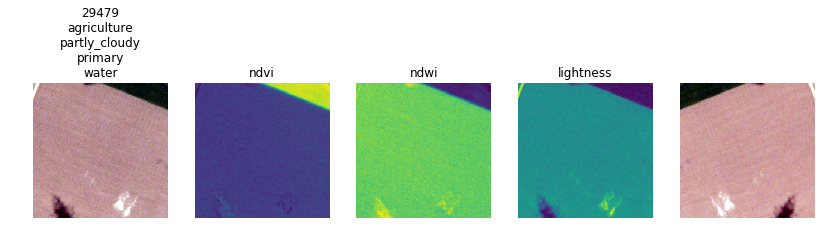

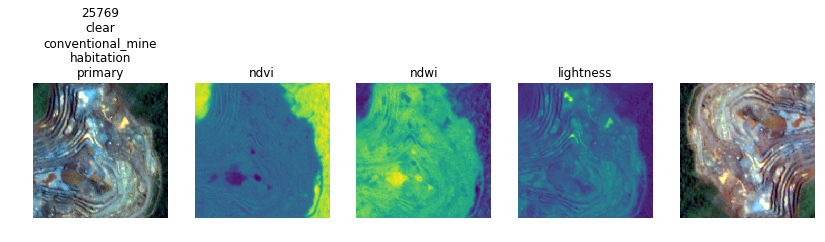

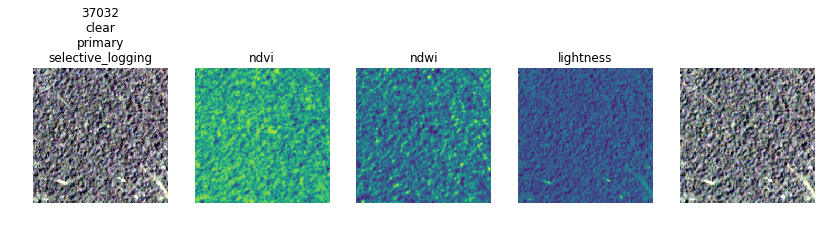

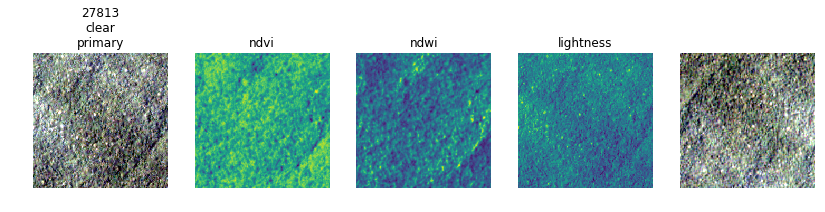

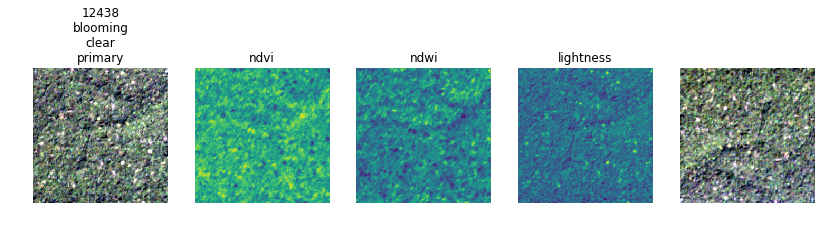

In [55]:
loop_max_counter = 1
for x, y, info in train_flow:
    
    print('--', x.shape, y.shape)
    print('--', x.min(), x.max(), x.mean(), x.std())
    print('--', y)
        
    n = 1
    for counter in range(params['batch_size']):
        if counter % n == 0:
            plt.figure(figsize=(14, 6))

        if channels_first:
            img = x[counter, :, :, :].transpose([1, 2, 0])
        else:
            img = x[counter, :, :, :]
        
        image_id, image_type = info[counter]
        caption = get_caption(*info[counter])
        
        rgb = to_rgb(img)
        ndvi = img[:,:,4]
        ndwi = img[:,:,5]
        lightness = img[:,:,6]
                
        plt.subplot(1, 5, 1)
        plt.imshow(scale_percentile(rgb))
        plt.title(image_id + "\n" + caption.replace(' ', '\n'))
        plt.axis('off')

        plt.subplot(1, 5, 2)  
        plt.title("ndvi")
        plt.imshow(ndvi)
        plt.axis('off')

        plt.subplot(1, 5, 3)  
        plt.title("ndwi")
        plt.imshow(ndwi)
        plt.axis('off')

        plt.subplot(1, 5, 4)  
        plt.title("lightness")
        plt.imshow(lightness)
        plt.axis('off')
        
        img_jpg = get_image_data(image_id, 'Train_jpg')
        
        plt.subplot(1, 5, 5)
        plt.imshow(scale_percentile(img_jpg))
        plt.axis('off')
 

        
    loop_max_counter -= 1
    if loop_max_counter == 0:
        break
    

In [42]:
from data_utils import get_label

[autoreload of xy_providers failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/Users/vfomin/Documents/ML/Kaggle/PlanetAmazonRainForest/common/xy_providers.py", line 162
    else:
    ^
IndentationError: expected an indented block
]


In [44]:
a = get_label('0', 'Train_tif', class_index=0)

In [47]:
np.concatenate((a, [0, ]))

array([0, 0, 0, 0, 0, 0, 0])

In [48]:
a

array([0, 0, 0, 0, 0, 0], dtype=uint8)

-- 0.0 0.0634766 1.49856e-05 0.000809806
-- 0.0 0.216611 0.000301519 0.00600632
-- 0.0 0.346593 0.0411561 0.100258
-- 0.0 0.216057 0.106454 0.0678328
-- 0.0 0.179308 0.0168705 0.0303361


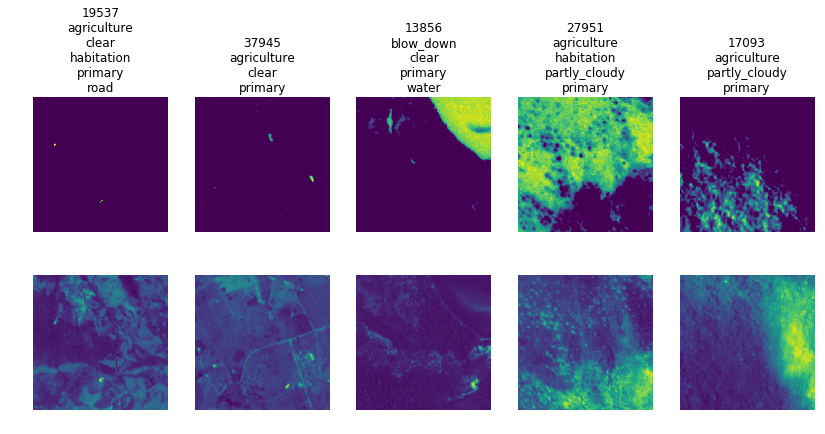

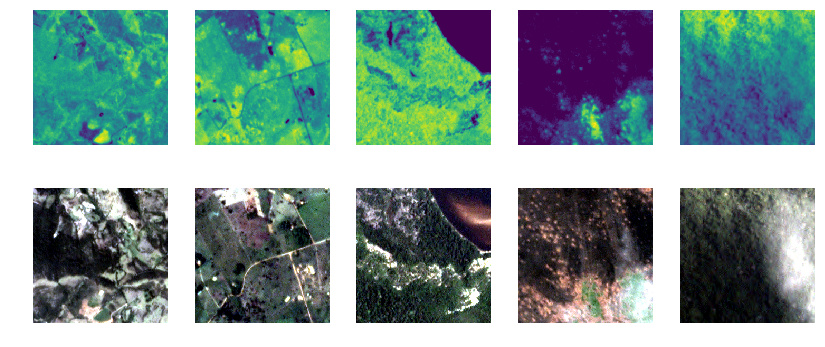

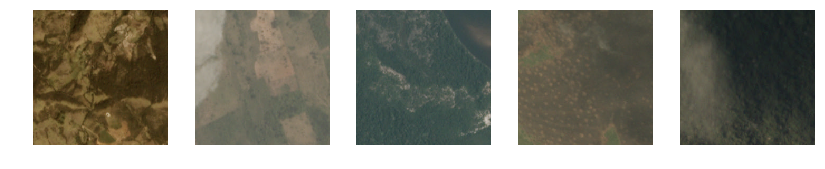

In [161]:
# loop_max_counter = 1
# for x, y, info in train_flow:
    
# #     print('--', x.shape, y.shape)
# #     print('--', x.min(), x.max(), x.mean(), x.std())
        
#     n = 5
#     for counter in range(params['batch_size']):
#         if counter % n == 0:
#             plt.figure(figsize=(14, 6))

#         if channels_first:
#             img = x[counter, :, :, :].transpose([1, 2, 0])
#         else:
#             img = x[counter, :, :, :]
        
#         image_id, image_type = info[counter]
#         caption = get_caption(*info[counter])
        
#         ndwi = to_ndwi(img)        
#         ndwi[ndwi < 0] = 0.0        
        
#         l32 = to_lightness(img)
        
#         print('--', ndwi.min(), ndwi.max(), ndwi.mean(), ndwi.std())
        
#         plt.subplot(2, n, counter % n + 1)
#         plt.imshow(ndwi)
#         plt.title(image_id + "\n" + caption.replace(' ', '\n'))
#         plt.axis('off')

#         plt.subplot(2, n, counter % n + 1 * n + 1)    
#         plt.imshow(l32)
#         plt.axis('off')
    
    
#     n = 5
#     for counter in range(params['batch_size']):
#         if counter % n == 0:
#             plt.figure(figsize=(14, 6))

#         if channels_first:
#             img = x[counter, :, :, :].transpose([1, 2, 0])
#         else:
#             img = x[counter, :, :, :]
        
#         ndvi = to_ndvi(img)
#         ndvi[ndvi < 0] = 0.0        
                
#         plt.subplot(2, n, counter % n + 1)
#         plt.imshow(ndvi)
#         plt.axis('off')

#         plt.subplot(2, n, counter % n + 1 * n + 1)    
#         plt.imshow(scale_percentile(to_rgb(img)[:,:,:3], q_min=2.5, q_max=97.5))
#         plt.axis('off')
        
#     n = 5
#     for counter in range(params['batch_size']):
#         if counter % n == 0:
#             plt.figure(figsize=(14, 6))

#         image_id, image_type = info[counter]
        
#         img_jpg = get_image_data(image_id, 'Train_jpg')
        
#         plt.subplot(1, n, counter % n + 1)
#         plt.imshow(img_jpg)
#         plt.axis('off')
    
        
        
#     loop_max_counter -= 1
#     if loop_max_counter == 0:
#         break
    

In [133]:
o[]

(256, 256, 4)

In [181]:
from keras.applications.imagenet_utils import _obtain_input_shape
from keras import backend as K

In [182]:
input_shape = (224, 224, 7)
_obtain_input_shape(input_shape,
                    default_size=227,
                    min_size=48,
                    data_format=K.image_data_format(),
                    include_top=False)

ValueError: The input must have 3 channels; got `input_shape=(224, 224, 7)`